Dataset Link: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [34]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Load and EDA

In [11]:
df = pd.read_csv('energydata_complete.csv')
#df.head()

In [12]:
# Initial cleaning
df['Appliances'] = df['Appliances'] + df['lights']
df = df.rename(columns={'Appliances': 'Usage'})

In [ ]:
df = df.drop(['lights', 'date', 'rv1', 'rv2'], axis = 1)
df.head()

In [14]:
# Seperating into X and y
X = df.drop('Usage', axis = 1)
y = df['Usage']

In [ ]:
# Checking for duplicates
print(X.duplicated())


In [ ]:
# General Statistics for the dataset
X.describe()

In [ ]:
# Checking for missing values
X.isna().sum()

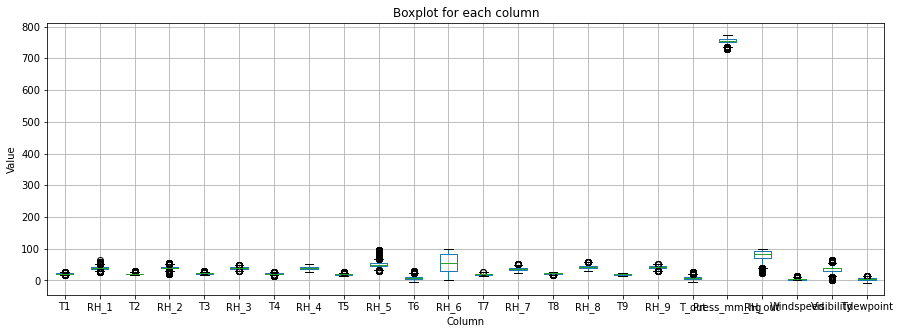

In [33]:
# Checking for outliers
# create a larger plot
fig, ax = plt.subplots(figsize=(15, 5))

# create a boxplot for each column
X.boxplot(ax=ax)

# set the title and axis labels
plt.title('Boxplot for each column')
plt.xlabel('Column')
plt.ylabel('Value')

# show the plot
plt.show()

<AxesSubplot:xlabel='Usage', ylabel='Count'>

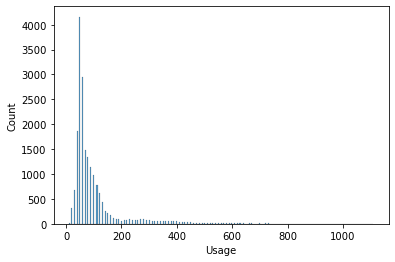

In [36]:
# Check the distribution of the target variable
sns.histplot(y)

In [ ]:
# Correlation Analysis

In [ ]:
# Visualization 